In [1]:
import time
import os

import torch
import sys
import os 
dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
sys.path.insert(0,dir_path)
from dataloader import Dataset_from_pkl
from model_cvae import CvaeFuture
from torch.utils.tensorboard import SummaryWriter
import torch.distributions as D
from train_with_future import get_ade_fde_vel
from visualize import visualize_single


In [2]:
training_set = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed/", data_files=["eth_train.pkl"])
training_generator = torch.utils.data.DataLoader(training_set, batch_size=1, shuffle=True)

test_set = Dataset_from_pkl("/home/robot/repos/trajectory-prediction/processed/", data_files=["eth_test.pkl"])
test_generator = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)
model = CvaeFuture(lstm_hidden_dim=64, num_layers=1, bidir=True, dropout_p=0.0, num_modes=30).to(device)
model.load_state_dict(torch.load("/home/robot/repos/trajectory-prediction/tb/CvaeFuture0.0005_hd_64_ed_0_nl_1@17.08.2020-19:03:59/CvaeFuture0.0005_hd_64_ed_0_nl_1@17.08.2020-19:03:59+best.pth"))



loading eth_train.pkl
loading eth_test.pkl
cuda


/home/robot/miniconda3/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

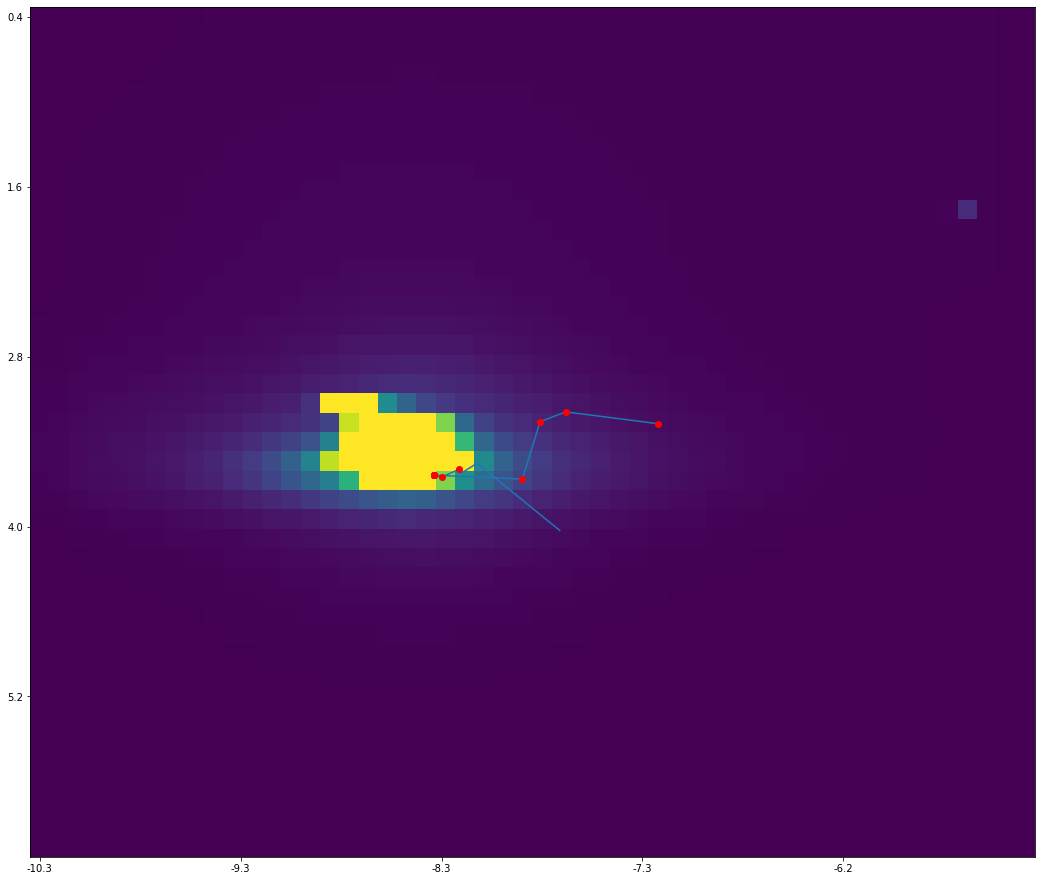

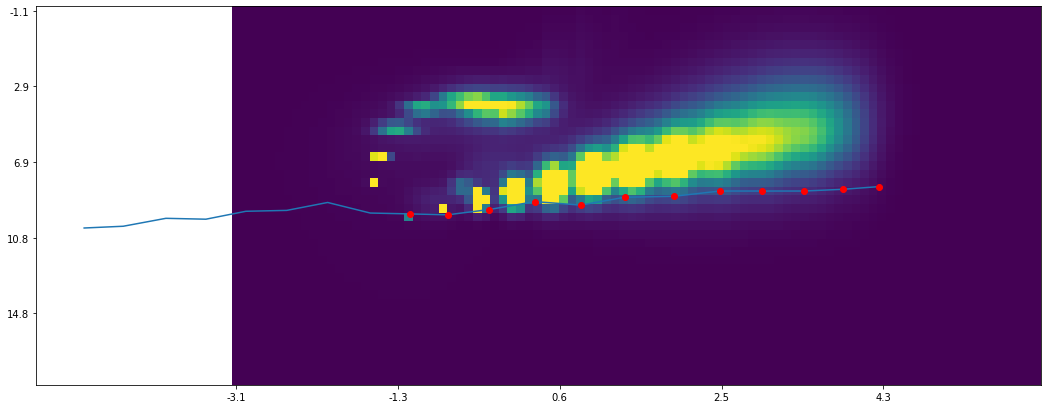

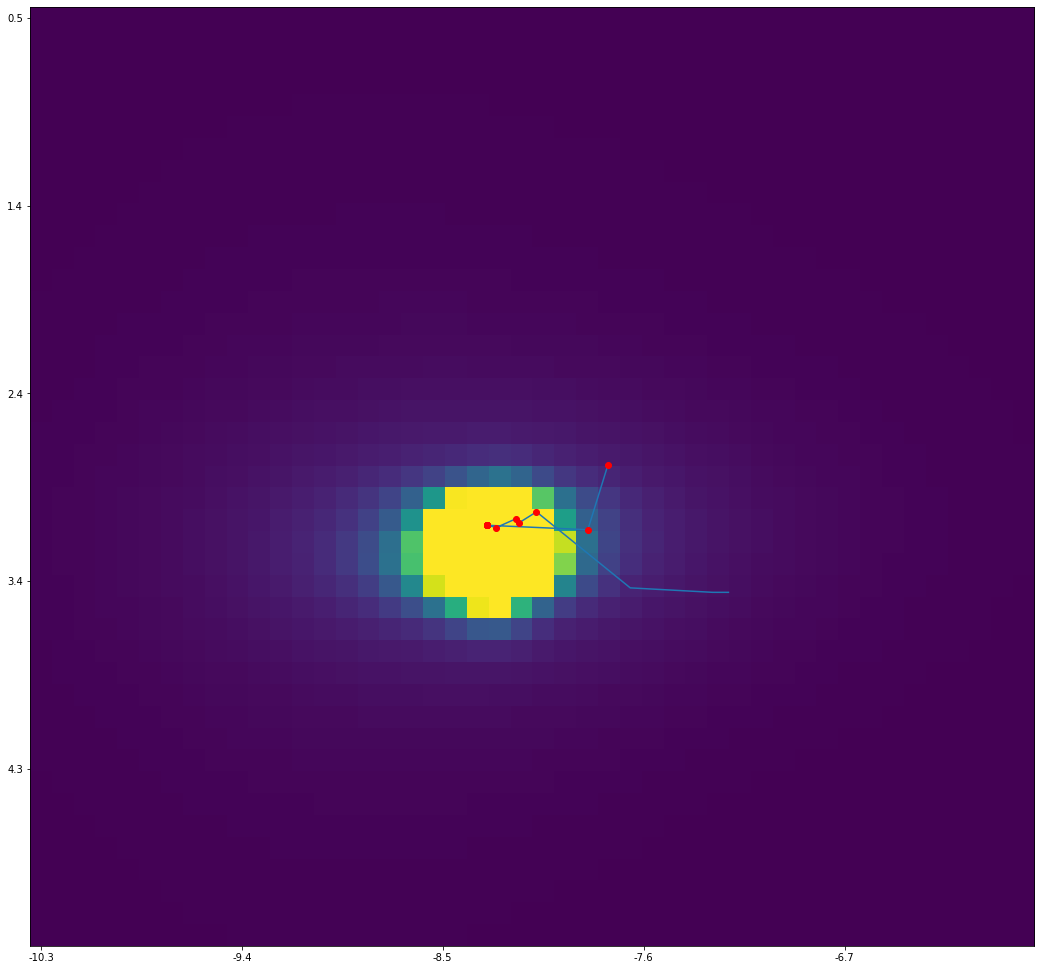

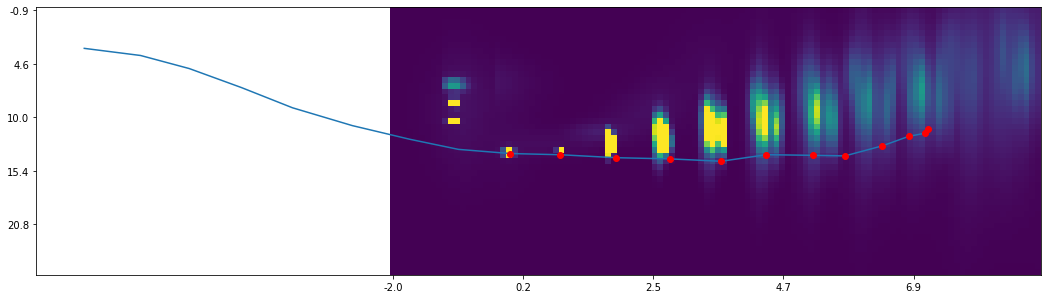

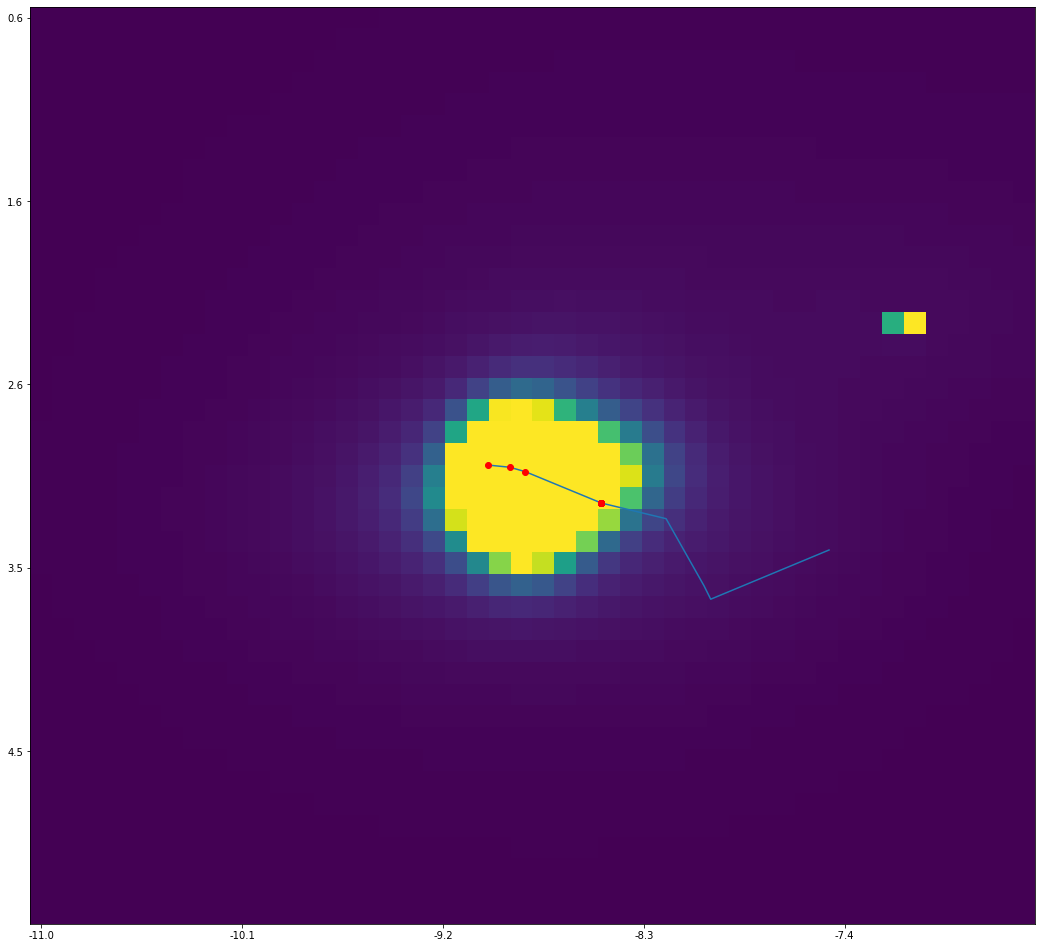

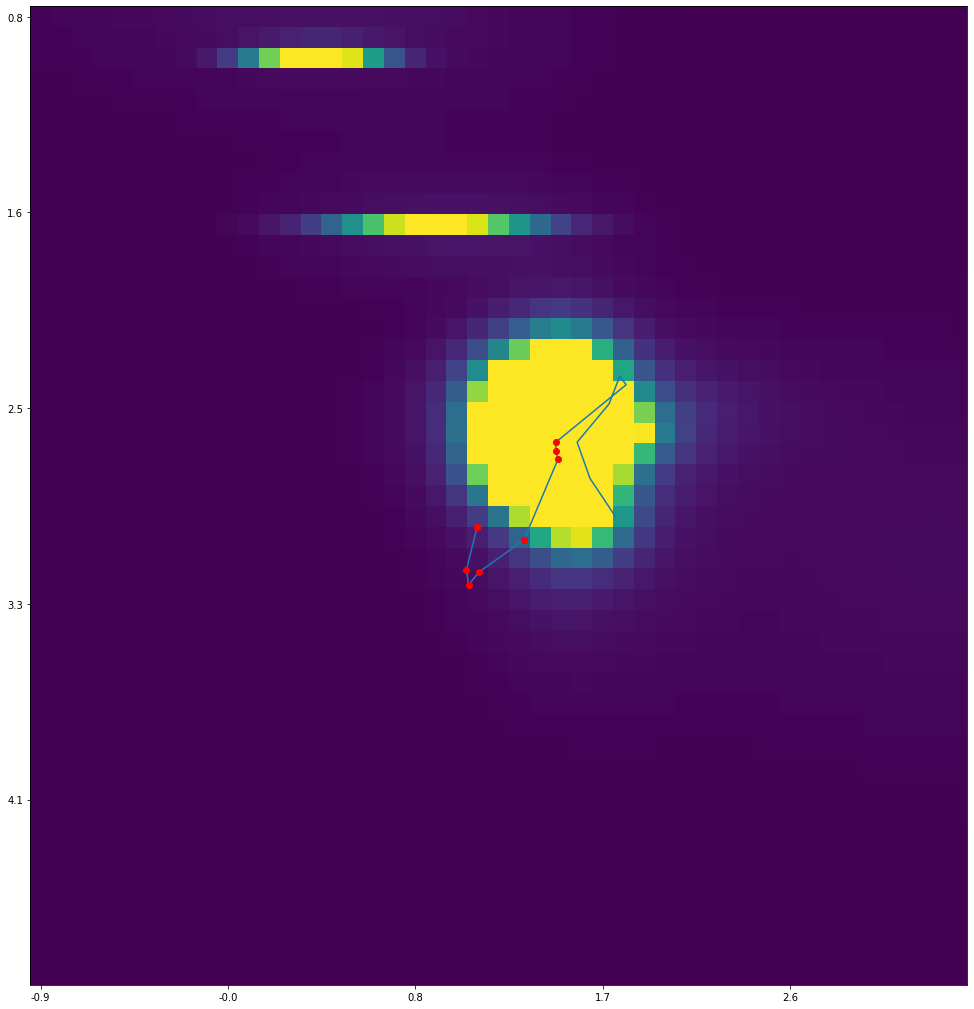

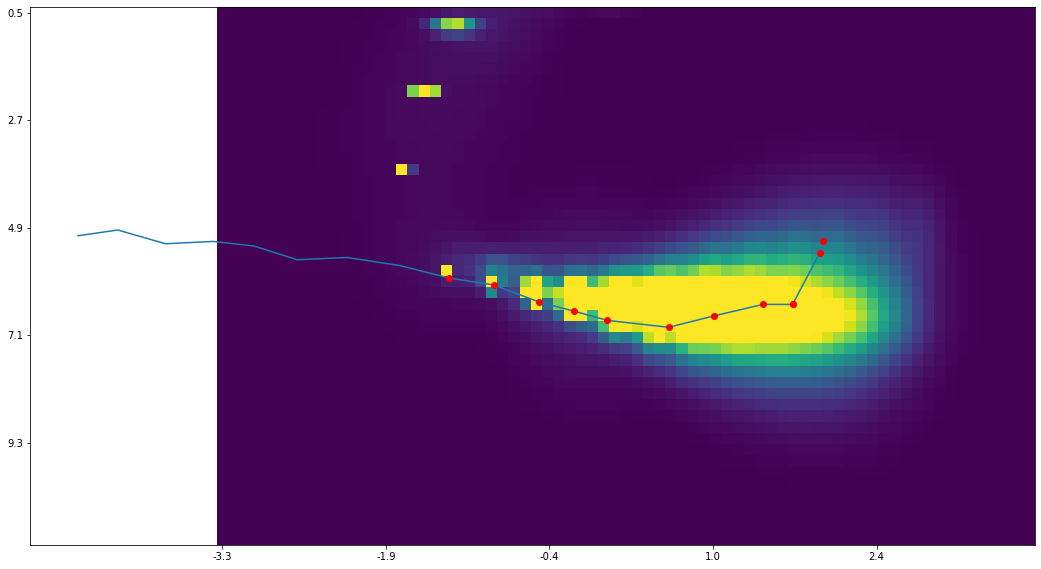

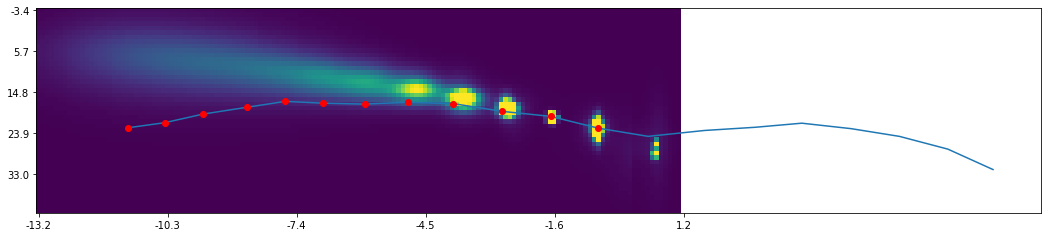

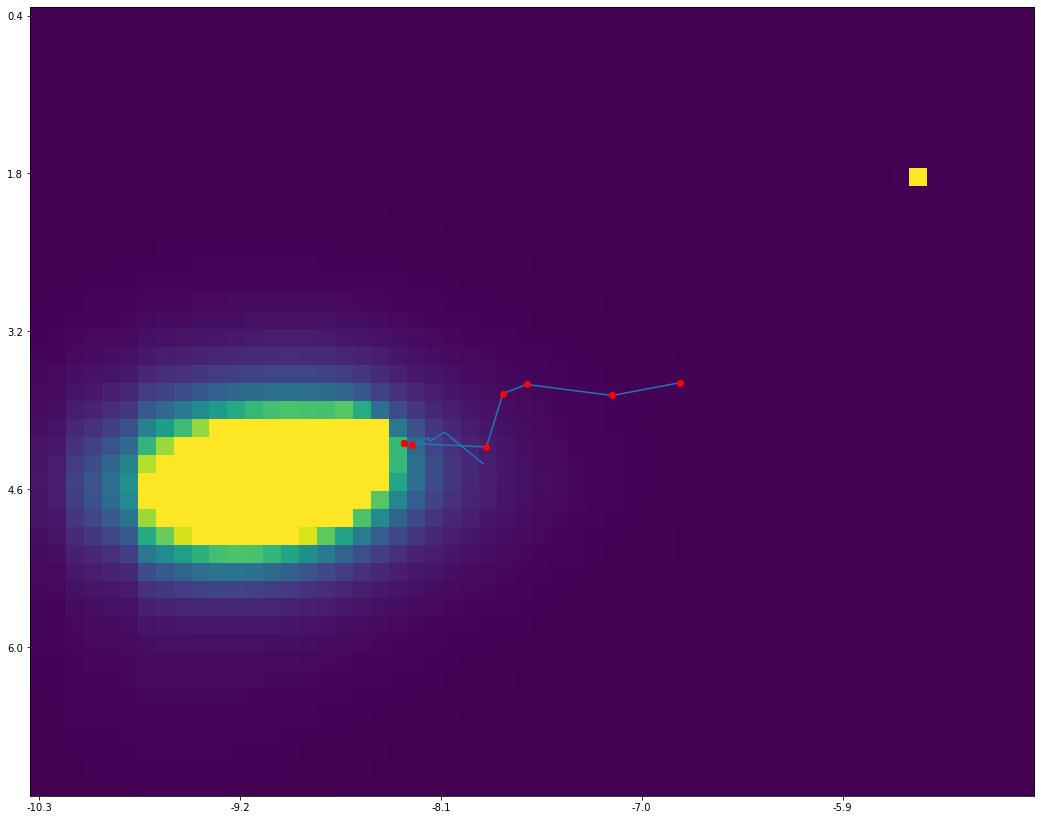

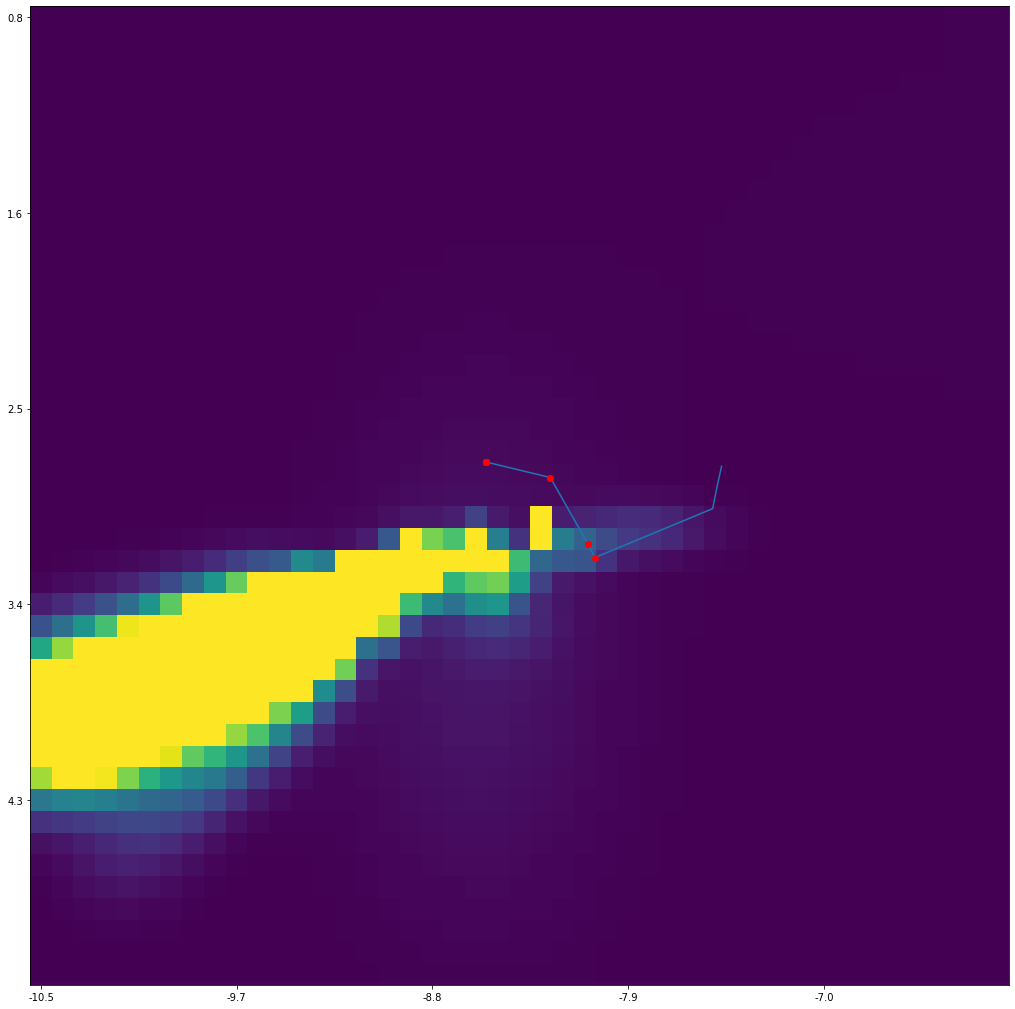

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    visualize_single(model, test_generator)

In [41]:
for batch_id, local_batch in enumerate(test_generator):
#     print(local_batch)
    local_batch = local_batch.to("cuda")
    prediction = model(local_batch[0, :, :, 2:8])
    predictions = torch.cat([prediction[i].mean for i in range(12)]).reshape(12, -1, 2).permute(1, 0, 2)
    print (predictions)


tensor([[[-7.2781e-01, -1.4621e+00],
         [ 9.3227e-02, -1.2839e+00],
         [ 1.0202e+00, -1.2299e+00],
         [ 1.9015e+00, -1.2093e+00],
         [ 2.8187e+00, -1.2490e+00],
         [ 3.6707e+00, -1.2880e+00],
         [ 4.5454e+00, -1.3603e+00],
         [ 5.3771e+00, -1.4198e+00],
         [ 6.2160e+00, -1.4960e+00],
         [ 7.0491e+00, -1.5727e+00],
         [ 7.8727e+00, -1.6518e+00],
         [ 8.7137e+00, -1.7430e+00]],

        [[-8.4330e-01, -7.0771e-01],
         [-6.3358e-04, -5.8472e-01],
         [ 9.2112e-01, -5.2861e-01],
         [ 1.8104e+00, -4.9171e-01],
         [ 2.6983e+00, -4.8532e-01],
         [ 3.5718e+00, -4.8712e-01],
         [ 4.4268e+00, -5.0327e-01],
         [ 5.2790e+00, -5.2892e-01],
         [ 6.1187e+00, -5.6055e-01],
         [ 6.9572e+00, -6.0370e-01],
         [ 7.7877e+00, -6.5338e-01],
         [ 8.6151e+00, -7.1156e-01]],

        [[-3.3641e+00,  1.2918e+00],
         [-2.3951e+00,  1.0913e+00],
         [-1.3798e+00,  8.5392e-01

tensor([[[-1.7814e-02, -9.6994e-03],
         [-3.0178e-02, -1.2110e-02],
         [-4.2804e-02, -1.3409e-02],
         [-5.5484e-02, -1.5492e-02],
         [-6.7872e-02, -1.8810e-02],
         [-8.0215e-02, -2.3350e-02],
         [-9.2848e-02, -2.8974e-02],
         [-1.0601e-01, -3.5517e-02],
         [-1.1979e-01, -4.2816e-02],
         [-1.3418e-01, -5.0726e-02],
         [-1.4910e-01, -5.9120e-02],
         [-1.6444e-01, -6.7888e-02]],

        [[ 2.3913e-02, -4.9815e-03],
         [ 4.8737e-02, -9.9010e-03],
         [ 7.1451e-02, -1.5208e-02],
         [ 9.2752e-02, -2.0821e-02],
         [ 1.1291e-01, -2.6705e-02],
         [ 1.3200e-01, -3.2590e-02],
         [ 1.5024e-01, -3.8479e-02],
         [ 1.6780e-01, -4.4372e-02],
         [ 1.8485e-01, -5.0284e-02],
         [ 2.0149e-01, -5.6232e-02],
         [ 2.1781e-01, -6.2230e-02],
         [ 2.3388e-01, -6.8286e-02]],

        [[ 4.2447e+00, -2.7170e-02],
         [ 4.8429e+00,  7.2244e-02],
         [ 5.6058e+00,  1.3513e-01

RuntimeError: stack expects a non-empty TensorList

In [44]:
t= torch.rand(3,3,2)
print (t[:, 2: ,:] )

print( t[:,-1,:])

tensor([[[0.3468, 0.2751]],

        [[0.1921, 0.9701]],

        [[0.5207, 0.6876]]])
tensor([[0.3468, 0.2751],
        [0.1921, 0.9701],
        [0.5207, 0.6876]])
